In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
from seaborn import heatmap

In [2]:
# データ読込
IN_DIR=os.path.join(os.curdir, 'in')
df = pd.read_csv(os.path.join(IN_DIR, 'rf_01.csv'),sep=';',header=0)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,1.0,1.0,2.0,0.0,2.0,0.0,0,6,0,...,2,NaN,0,1,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,7.0,2.0,3.0,0.0,0.0,0.0,1,6,0,...,4,NaN,0,1,1.1,93.994,-36.4,4.855,5191.0,0
2,25,7.0,1.0,3.0,0.0,2.0,0.0,1,4,4,...,1,NaN,0,1,1.4,94.465,-41.8,4.962,5228.1,0
3,38,7.0,1.0,2.0,0.0,NaN,NaN,1,4,0,...,3,NaN,0,1,1.4,94.465,-41.8,4.959,5228.1,0
4,47,0.0,1.0,6.0,0.0,2.0,0.0,0,7,1,...,1,NaN,0,1,-0.1,93.200,-42.0,4.191,5195.8,0


In [3]:
# 欠損値の補完 
# pdaysは平均値補完
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(df[["pdays"]])
df["pdays"]=imp.transform(df[["pdays"]]).ravel()

# 上記以外は最頻値補完
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(df[["job"]])
df["job"]=imp.transform(df[["job"]]).ravel()

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(df[["marital"]])
df["marital"]=imp.transform(df[["marital"]]).ravel()

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(df[["education"]])
df["education"]=imp.transform(df[["education"]]).ravel()

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(df[["default"]])
df["default"]=imp.transform(df[["default"]]).ravel()

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(df[["housing"]])
df["housing"]=imp.transform(df[["housing"]]).ravel()

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(df[["loan"]])
df["loan"]=imp.transform(df[["loan"]]).ravel()

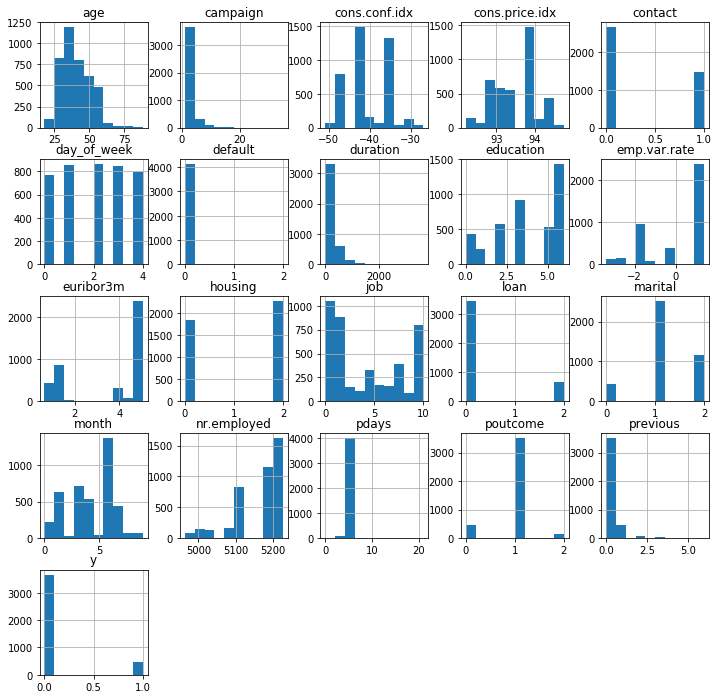

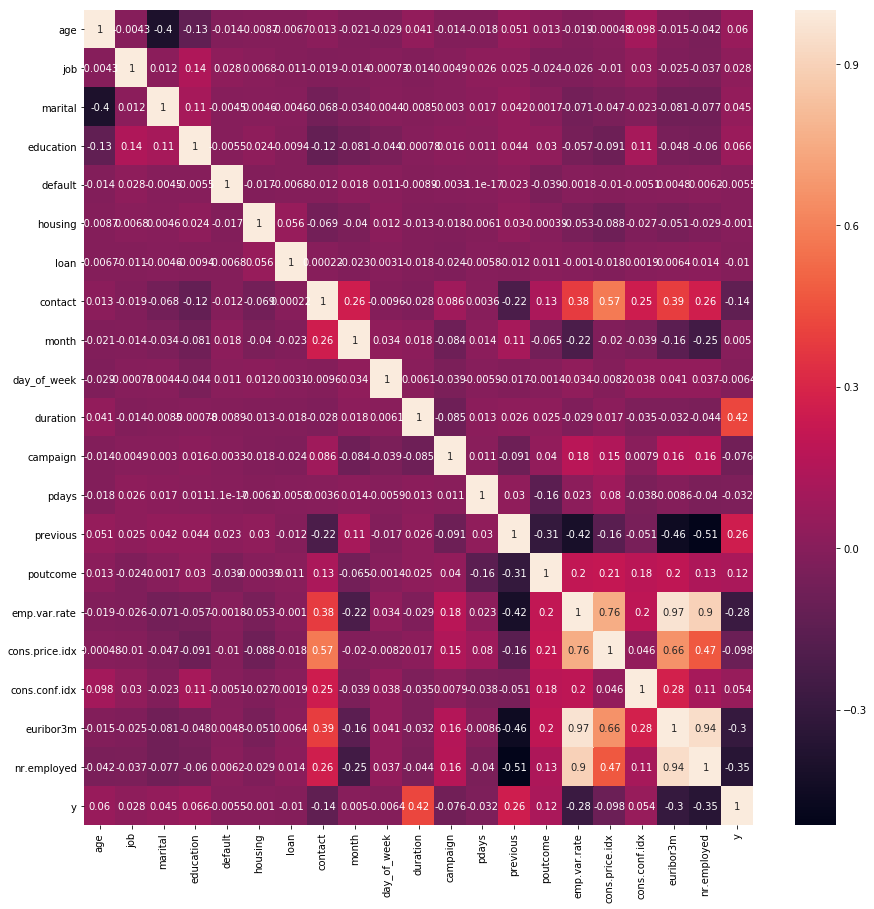

In [4]:
#
# 現状把握
#
# 各データ分布を表示
df.hist(figsize=(12, 12))
# 相関分析
plt.figure(figsize=(15,15))
heatmap(df.corr(), annot=True)
plt.show()

In [5]:
# 分布確認時に"default"は値が一種類しかないため特徴量から除外
df.drop(['default'], axis=1, inplace=True)
# 目的変数に対して相関が高いものを特徴量から除外
df.drop(['duration', 'euribor3m', 'nr.employed'], axis=1, inplace=True)

In [6]:
# 前処理後のCSV出力
OUT_DIR=os.path.join(os.curdir, 'out')
df.to_csv(os.path.join(OUT_DIR, 'rf_fix.csv'),sep=';',index=False)
df.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,y
0,30,1.0,1.0,2.0,2.0,0.0,0,6,0,2,5.8625,0,1,-1.8,92.893,-46.2,0
1,39,7.0,2.0,3.0,0.0,0.0,1,6,0,4,5.8625,0,1,1.1,93.994,-36.4,0
2,25,7.0,1.0,3.0,2.0,0.0,1,4,4,1,5.8625,0,1,1.4,94.465,-41.8,0
3,38,7.0,1.0,2.0,2.0,0.0,1,4,0,3,5.8625,0,1,1.4,94.465,-41.8,0
4,47,0.0,1.0,6.0,2.0,0.0,0,7,1,1,5.8625,0,1,-0.1,93.200,-42.0,0


In [7]:
#
# 特徴量の選択
#
# 説明変数,目的変数の抽出
X = df.ix[:,0:-1].values
y = df.iloc[:,-1].values
# 学習データとテストデータの分離
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

C:\usr\dev\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


In [8]:
# ランダムフォレスト
forest = RandomForestClassifier(min_samples_leaf=3, random_state=1)
forest.fit(X_train, y_train)

#評価
print('Train score: {}'.format(forest.score(X_train, y_train)))
print('Test score: {}'.format(forest.score(X_test, y_test)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, forest.predict(X_test))))
print('f1 score: {:.3f}'.format(f1_score(y_test, forest.predict(X_test))))

Train score: 0.93175074184
Test score: 0.912621359223
Confusion matrix:
[[364   9]
 [ 27  12]]
f1 score: 0.400


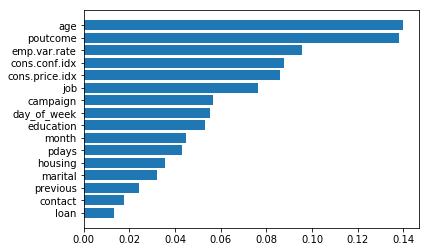

In [9]:
# 説明変数の重要度を表示
values, names = zip(*sorted(zip(forest.feature_importances_, df.columns)))
#plt.figure(figsize=(12,12))
plt.barh(range(len(names)), values, align='center')
plt.yticks(range(len(names)), names)
plt.show()

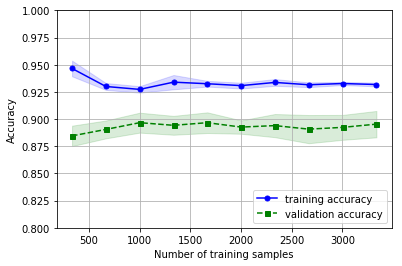

In [10]:
#　学習曲線
pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('clf', forest),
])
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    n_jobs=1,
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
    train_sizes,
    train_mean,
    color='blue',
    marker='o',
    markersize=5,
    label='training accuracy',
)
plt.fill_between(
    train_sizes,
    train_mean + train_std,
    train_mean - train_std,
    alpha=0.15,
    color='blue',
)
plt.plot(
    train_sizes,
    test_mean,
    color='green',
    linestyle='--',
    marker='s',
    markersize=5,
    label='validation accuracy',
)
plt.fill_between(
    train_sizes,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15,
    color='green',
)

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

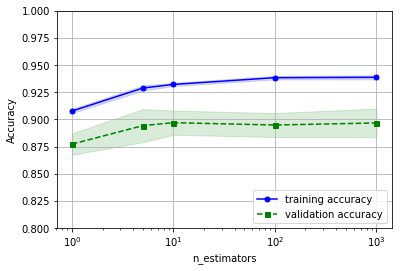

In [11]:
# 検証曲線
"""
param_name: 'clf__'の後に各アルゴリズムで使用するパラメータ名で指定する。
　LogisticRegression - clf__C
 SVM - clf__gamma
 RandomForestClassifier - clf__n_estimators
"""
param_range = [1,5,10,100,1000]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='clf__n_estimators',
    param_range=param_range,
    cv=10,
    n_jobs=1,
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
    param_range,
    train_mean,
    color='blue',
    marker='o',
    markersize=5,
    label='training accuracy',
)
plt.fill_between(
    param_range,
    train_mean + train_std,
    train_mean - train_std,
    alpha=0.15,
    color='blue',
)
plt.plot(
    param_range,
    test_mean,
    color='green',
    linestyle='--',
    marker='s',
    markersize=5,
    label='validation accuracy',
)
plt.fill_between(
    param_range,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15,
    color='green',
)

plt.grid()
plt.xscale('log')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

In [12]:
#
# グリッドサーチで最適なパラメータの探索
#
"""
 ・n_estimators:木の数(特徴量Nの場合、N^1/2がよい?)
 ・max_features:各決定木で分類に使用する説明変数の数
 ・max_depth：各決定木の深さ
 ・min_samples_leaf:決定木の葉に分類されるサンプル数

  http://ohke.hateblo.jp/entry/2017/08/04/230000
  http://d.hatena.ne.jp/shakezo/20121221/1356089207
"""
# ハイパーパラメータ
forest_grid_param = {
    'n_estimators': [225,250,260],
    'max_features': [1, 'auto', None],
    'max_depth': [1, 5, 10, None],
    'min_samples_leaf': [1, 2, 4,]
}

# スコア方法をF1に設定
f1_scoring = make_scorer(f1_score,  pos_label=1)
# グリッドサーチで学習
forest_grid_search = GridSearchCV(RandomForestClassifier(
        random_state=0, n_jobs=-1), forest_grid_param, 
scoring=f1_scoring, cv=4)
forest_grid_search.fit(X_train, y_train)

C:\usr\dev\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [225, 250, 260], 'max_features': [1, 'auto', None], 'max_depth': [1, 5, 10, None], 'min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, pos_label=1), verbose=0)

In [13]:
# 結果
print('Best parameters: {}'.format(forest_grid_search.best_params_))
print('Best score: {:.3f}'.format(forest_grid_search.best_score_))

Best parameters: {'max_features': None, 'n_estimators': 225, 'max_depth': None, 'min_samples_leaf': 1}
Best score: 0.352


In [14]:
#
# 再学習
# 最適パラメータ使って評価
#
best_params = forest_grid_search.best_params_
forest = RandomForestClassifier(random_state=0, n_jobs=1, 
                                max_depth=best_params['max_depth'], 
                                max_features=best_params['max_features'], 
                                min_samples_leaf=best_params['min_samples_leaf'],
                                n_estimators=best_params['n_estimators'])
forest.fit(X_train, y_train)
print('Train score: {:.3f}'.format(forest.score(X_train, y_train)))
print('Test score: {:.3f}'.format(forest.score(X_test, y_test)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, forest.predict(X_test))))
print('f1 score: {:.3f}'.format(f1_score(y_test, forest.predict(X_test))))

Train score: 0.999
Test score: 0.908
Confusion matrix:
[[363  10]
 [ 28  11]]
f1 score: 0.367
